# Test of Chunks, zarr, kerchunk, remote, posix, OSDF, Spectrum Scale S3, etc., etc.

In [13]:
import sys
import os
import glob
import math
import xarray
import dask
from random import randint
from dask.distributed import Client, progress
import pandas
import logging

### Start up dask

In [14]:
client = Client(threads_per_worker=4, n_workers=8,silence_logs=logging.ERROR)
client

/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42423 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/42423/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/42423/status,Workers: 8
Total threads: 32,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36917,Workers: 8
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/42423/status,Total threads: 32
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:40697,Total threads: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/38759/status,Memory: 512.00 MiB
Nanny: tcp://127.0.0.1:36323,


# NetCDF4 Chunk Tests

#### First, let's start by comparing large chunks vs small chunks vs default vs normalized
In this case I'll use a couple weeks worth of ERA5 Temperature data

In [ ]:
large_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/big_chunks/'
large_chunks_files = glob.glob(large_chunks_path+'*')
large_chunks_files.sort()
small_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/little_chunks/'
small_chunks_files = glob.glob(small_chunks_path+'*')
small_chunks_files.sort()
even_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/even_chunks/'
even_chunks_files = glob.glob(even_chunks_path+'*')
even_chunks_files.sort()
default_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/default_chunks/'
default_chunks_files = glob.glob(default_chunks_path+'*')
default_chunks_files.sort()
print(f'Number of files: {len(default_chunks_files)}')
print(f'Typical size ~{math.floor(os.path.getsize(default_chunks_files[0])/1000000)} MB')

### default chunks

In [ ]:
sample_file_DC = default_chunks_files[0]
print(os.path.basename(sample_file_DC))
DC_ds = xarray.open_dataset(sample_file_DC)
print(f"Chunksizes are: {DC_ds.T.encoding['chunksizes']}")
print(f"shape is: {DC_ds.T.shape}")
chunk_size =  1
for i in DC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

### large chunks

In [ ]:
sample_file_LC = large_chunks_files[0]
print(os.path.basename(sample_file_LC))
LC_ds = xarray.open_dataset(sample_file_LC)
print(f"Chunksizes are: {LC_ds.T.encoding['chunksizes']}")
print(f"shape is: {LC_ds.T.shape}")
chunk_size =  1
for i in LC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

### small chunks

In [ ]:
sample_file_SC = small_chunks_files[0]
print(os.path.basename(sample_file_SC))
SC_ds = xarray.open_dataset(sample_file_SC)
print(f"Chunksizes are: {SC_ds.T.encoding['chunksizes']}")
print(f"shape is: {SC_ds.T.shape}")
chunk_size =  1
for i in SC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

### even chunks

In [ ]:
sample_file_EC = even_chunks_files[0]
print(os.path.basename(sample_file_EC))
EC_ds = xarray.open_dataset(sample_file_EC)
print(f"Chunksizes are: {EC_ds.T.encoding['chunksizes']}")
print(f"shape is: {EC_ds.T.shape}")
chunk_size =  1
for i in EC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

## Make some measurements

#### Single point

In [ ]:
%%timeit -r1 -n1 -o
val = DC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

In [ ]:
DC_single_point = _.average

In [ ]:
%%timeit -r1 -n1 -o
val = LC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

In [ ]:
LC_single_point = _.average

In [ ]:
%%timeit -r1 -n1 -o
val = SC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

In [ ]:
SC_single_point = _.average

In [ ]:
%%timeit -r1 -n1 -o
val = EC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

In [ ]:
EC_single_point = _.average

In [ ]:
df = pandas.DataFrame(data=[DC_single_point,LC_single_point,SC_single_point,EC_single_point],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

In [ ]:
df = pandas.DataFrame(data=[DC_single_point,SC_single_point,EC_single_point],
                index=['Default','Small','Even'])
df.plot(kind='bar')

#### Full grid

In [ ]:
%%timeit -r1 -n1 -o
DC_ds.T.isel(time=randint(0,24),level=36).plot()

In [ ]:
DC_full_grid = _.average

In [ ]:
%%timeit -r1 -n1 -o
LC_ds.T.isel(time=randint(0,24),level=36).plot()

In [ ]:
LC_full_grid = _.average

In [ ]:
%%timeit -r1 -n1 -o
SC_ds.T.isel(time=randint(0,24),level=36).plot()

In [ ]:
SC_full_grid = _.average

In [ ]:
%%timeit -r1 -n1 -o
EC_ds.T.isel(time=randint(0,24), level=36).plot()

In [ ]:
EC_full_grid = _.average

In [ ]:
df = pandas.DataFrame(data=[DC_full_grid,LC_full_grid,SC_full_grid,EC_full_grid],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

In [ ]:
df = pandas.DataFrame(data=[DC_full_grid,SC_full_grid,EC_full_grid],
                index=['Default','Small','Even'])
df.plot(kind='bar')

#### Time Series

In [ ]:
%%timeit -r1 -n1 -o
DC_ds.T.isel(level=27,latitude=500, longitude=500).plot()


In [ ]:
DC_timeseries = _.average

In [ ]:
%%timeit -r1 -n1 -o
LC_ds.T.isel(level=27,latitude=500, longitude=500).plot()

In [ ]:
LC_timeseries = _.average

In [ ]:
%%timeit -r1 -n1 -o
SC_ds.T.isel(level=27,latitude=500, longitude=500).plot()

In [ ]:
SC_timeseries = _.average

In [ ]:
%%timeit -r1 -n1 -o
EC_ds.T.isel(level=27,latitude=500, longitude=500).plot()

In [ ]:
EC_timeseries = _.average

In [ ]:
df = pandas.DataFrame(data=[DC_timeseries,LC_timeseries,SC_timeseries,EC_timeseries],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

### Full file

In [ ]:
%%timeit -r1 -n1 -o
print(DC_ds.T.mean().data)

In [ ]:
DC_full = _.average

In [ ]:
%%timeit -r1 -n1 -o
print(LC_ds.T.mean().data)

In [ ]:
LC_full = _.average

In [ ]:
%%timeit -r1 -n1 -o
print(SC_ds.T.mean().data)

In [ ]:
SC_full = _.average

In [ ]:
%%timeit -r1 -n1 -o
print(EC_ds.T.mean().data)

In [ ]:
EC_full = _.average

In [ ]:
df = pandas.DataFrame(data=[DC_full,LC_full,SC_full,EC_full],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

### Test combined datasets

In [ ]:
%%time
ds = xarray.open_mfdataset(small_chunks_path+'*')
ds

In [ ]:
%%time
ds.T.isel(time=randint(0,24),level=36).plot()

In [ ]:
%%time
ds.T.isel(level=35,latitude=45, longitude=500).plot()

In [ ]:
%%time
ds = xarray.open_mfdataset(large_chunks_path+'*')
ds

# Campaign vs Luster 

In [5]:
default_chunks_path_luster = '/glade/derecho/scratch/rpconroy/era5_chunks/default_chunks/'
default_chunks_files_luster = glob.glob(default_chunks_path_luster+'*')
ds_luster = xarray.open_mfdataset(default_chunks_files_luster)

In [6]:
default_chunks_path_cs = '/gpfs/csfs1/collections/rda/data/harshah/rpconroy/era5_chunks/default_chunks/'
default_chunks_files_cs = glob.glob(default_chunks_path_cs+'*')
ds_campaign = xarray.open_mfdataset(default_chunks_files_cs)

In [7]:
little_chunks_path_luster = '/glade/derecho/scratch/rpconroy/era5_chunks/little_chunks/'
little_chunks_files_luster = glob.glob(little_chunks_path_luster+'*')
ds_luster_mc = xarray.open_mfdataset(little_chunks_files_luster)

In [8]:
little_chunks_path_cs = '/gpfs/csfs1/collections/rda/data/harshah/rpconroy/era5_chunks/little_chunks/'
little_chunks_files_cs = glob.glob(little_chunks_path_luster+'*')
ds_campaign_mc = xarray.open_mfdataset(little_chunks_files_cs)

5min 5s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 5min 5s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

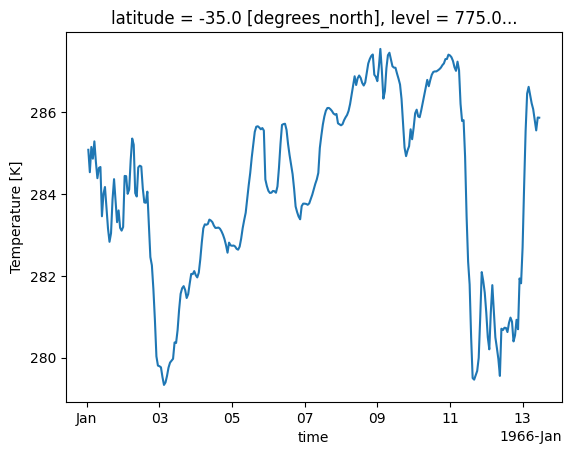

In [9]:
%%timeit -r1 -n1 -o
ds_campaign.T.isel(time=slice(1,300),level=27,latitude=500, longitude=500).plot()

In [10]:
campaign_time = _.average

In [12]:
%%timeit -r1 -n1 -o
print(ds_campaign_mc.T.isel(time=slice(1,300),level=27).mean().compute())

KeyboardInterrupt: 

In [ ]:
campaign_time_mc = _.average

2024-08-20 13:35:00,227 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/worker.py", line 1254, in heartbeat
    response = await retry_operation(
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/utils_comm.py", line 433, in retry
    return await coro()
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-pack

In [ ]:
%%timeit -r1 -n1 -o
ds_luster.T.isel(time=slice(1,300),level=27,latitude=500, longitude=500).plot()

In [ ]:
luster_time = _.average

In [ ]:
%%timeit -r1 -n1 -o
print(ds_luster_MC.T.isel(time=slice(1,300),level=27).mean().load())

In [ ]:
luster_time_mc = _.average

In [ ]:
df = pandas.DataFrame(data=[luster_time, campaign_time],
                index=['Luster', 'Campaign'])
df.plot(kind='bar')                                                                                                                                                                                              

In [ ]:
df = pandas.DataFrame(data=[luster_time_mc, campaign_time_mc],
                index=['Luster', 'Campaign'])
df.plot(kind='bar')        

2024-08-20 13:11:50,243 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:32849'. Shutting down.
2024-08-20 13:11:50,286 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/worker.py", line 1254, in heartbeat
    response = await retry_operation(
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
  File "/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distrib

# Kerchunk Tests

In [23]:
catalog_root = 'https://data.rda.ucar.edu/harshah/rpconroy/era5_chunks/'
                                  #    harshah/rpconroy/era5_chunks/big_chunks-remote.json
LC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'big_chunks-remote.json'}, 'consolidated':False},chunks=False)
DC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'default_chunks-remote.json'}, 'consolidated':False},chunks=False)
SC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'little_chunks-remote.json'}, 'consolidated':False},chunks=False)
EC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'even_chunks-remote.json'}, 'consolidated':False},chunks=False)

In [25]:
EC_ds

<xarray.Dataset> Size: 114GB
Dimensions:    (time: 744, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6kB 1966-01-01 ... 1966-01-31T23:00:00
Data variables:
    T          (time, level, latitude, longitude) float32 114GB dask.array<chunksize=(8, 9, 180, 360), meta=np.ndarray>
    utc_date   (time) int32 3kB dask.array<chunksize=(8,), meta=np.ndarray>
Attributes:
    CONVERSION_DATE:      Thu Aug 18 07:41:03 MDT 2022
    CONVERSION_PLATFORM:  Linux r1i5n29 4.12.14-95.51-default #1 SMP Fri Apr ...
    Conventions:          CF-1.6
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.8.1
    history:              Thu Aug 18 07:41:34 2022: ncks -4 --ppc default=7 e...

In [ ]:
%%time
ds_NC.T.isel(level=35,latitude=45, longitude=500).plot()